# 论文

这次的图像分割实例是复现了论文[U-Net- Convolutional Networks for Biomedical Image Segmentation](assets/U-Net-%20Convolutional%20Networks%20for%20Biomedical%20Image%20Segmentation.pdf),这篇论文提出了一个U型的神经网络。

该网络的前半部分是通过卷积核将低channel图像（RGB为3 channels）抬高到1024 channels，图像大小经过各层max pooling将会变小，可以有效从图像中提取特征，这部分我称之为**收缩(Contract)**。U-Net的后半部分是将高channel的部分扩张到低channel（若为单分类，channel可以为1，多分类时channel为分类数），图像大小经过Unsample将会变大，这部分我称之为**扩展(Expand)**。

在U型对称的部分（我把这归为一个Block）之间通过shortcut进行连接。
这种残差式的网络可以让梯度更有效地传播到前面，同时由于U型网络的后半部分为扩张，使用前半部分的Block数据可以保证后半部分Block还原时不失真。

![U-Net](assets/UNet.png)

# 参考

复现论文的时候我参考了GitHub上的另一个实现[milesial/Pytorch-UNet](https://github.com/milesial/Pytorch-UNet)，该实现对原论文进行了一定的修改，主要在于：
- 在网络的收缩最后部分，没有遵循论文中先收缩至1024 channels，再2*2卷积至512 channels，最后拼接成1024 channel；而是采用了直接收缩至512 channels。

- 网络的升采样没有采用论文作者描述的先Upsample，再$2*2$卷积减少channel的方式，而是直接从n channels收缩到$n/4$ channels的方式。

- 原论文中因为经过类型为valid的卷积层，导致图像的大小有所减小，因此shortcut时对原图像直接进行暴力裁剪，再拼接到扩张后的图片channels上；该项目中是对扩张后的图片进行四周补齐，避免最后遮罩层施加到原图时的缩放操作。

- 原论文输出channel为2，应该是原作者想使用one hot进行图层分离；该项目由于需求是只需分理处图片中的车，因此输出channel为1，用sigmoid函数进行0和1的分离。

- 原论文优化器使用带动量的SGD，项目使用RMSprop。

# 实现
这里的网络结构我还是基本遵循原论文的意愿，不同是shortcut参考Github项目中，用小图补齐至大图的方式，以及用sigmoid分离图层的方式，而非原文中分成两类的方式。

多类图像分割可以采用多channel输出，然后对每一像素进行One Hot编码，对输出数据和Label数据使用CrossEntropy函数计算损失即可（这里遵照了论文原意）。

数据集由于难找且庞大，再加上设备计算资源不足，这里采用该项目所使用的的单分类数据集。

网络定义位于[UNet.py](UNet.py)，结构为：

In [1]:
from UNet import UNet

net = UNet(in_channels=3, classes=1)  # 输入为RGB三通道图片，输出为经过sigmoid的单通道图像
print(net)

UNet(
  (contract_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contract_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=

图像的预处理位于[data_process.py](data_process.py)，其中make_train_and_validation_set_list函数负责将数据集划分为训练集和验证集


pyTorch数据预处理类位于[data.py](data.py)，负责将输入的图像numpy化，再转化为Tensor。

这里值得注意的一点是，数据集中的label图像为8bit位图，
直接使用torchvision中的ToTensor会导致图像全黑，推测可能ToTensor底层使用像素除以255的方式归一化，8bit数值为整型，因此导致tensor中的像素值
直接被清零，因此需要将label图像转为float32类型的numpy array。

网络训练位于[train.py](train.py)，使用TensorBoard使训练可视化。由于算力不足，训练时暂免去对数据的测试，且进行5轮训练，同时由于带有显卡的机器
显存不足，一批只能训练一张经过裁剪的图片。因此配置如下：

In [ ]:
import torch
from UNet import UNet
import logging
from train import train

in_dir = "data/kaggle/train"
out_dir = "data/kaggle/train_masks"
train_lst_path = "data/kaggle/train.txt"
val_lst_path = "data/kaggle/val.txt"
check_points = "check_points/"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(F"Using {device}")
net = UNet(in_channels=3, classes=1)

load_path = ""
if load_path != "":
    net.load_state_dict(
        torch.load(load_path, map_location=device)
    )

try:
    train(net=net, train_ids_file_path=train_lst_path, val_ids_file_path=val_lst_path,
          in_dir_path=in_dir, mask_dir_path=out_dir, check_points=check_points,
          epochs=5, batch_size=1,learning_rate=0.1, device=device
          )
except Exception as e:
    logging.error(e)
    torch.save(net.state_dict(), 'savednet.pth')
    logging.info("saved")


训练过程中，损失函数曲线如下

![loss](assets/loss.png)

实例图像如下（masks/origin为原图，masks/origin为真实的遮罩层，masks/pred为预测的遮罩层）
![images](assets/image.png)

按训练过程中的图像来看，网络搭建是比较成功的。

# 预测

只需输入网络参数保存的路径、图片地址和缩放倍数（用以加速）就可以提取出被分割出的对象。

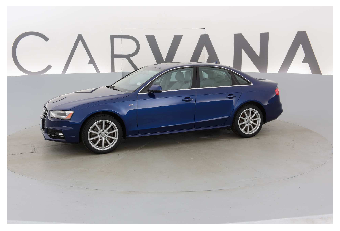

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

load_path = "CP_epoch3.pth"
img_path = "data/kaggle/train/0cdf5b5d0ce1_04.jpg"
origin = Image.open(img_path)

%matplotlib inline
plt.imshow(origin)
plt.axis('off')
plt.show()

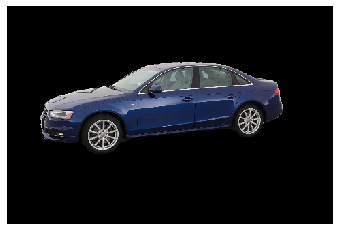

In [2]:
from predict import predict

img = predict(load_path, img_path, 4)

%matplotlib inline
plt.imshow(img)
plt.axis('off')
plt.show()


*date: 2020-3-7*
